### About
2.4_gmm-hmm
Optimizes and runs the GMM-HMM model in Pytorch using the Adam SGD and predicts RNA Pol signals using the trained model.

Code adapted from  https://github.com/lorenlugosch/pytorch_HMM

In [1]:
# import packages
import torch
import numpy as np
torch.manual_seed(1)
import torch.utils.data
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm # for displaying progress bar
import pandas as pd
from sklearn.mixture import GaussianMixture
import os
import seaborn as sns
from scipy.stats import pearsonr
import lightning.pytorch as pl

from sys import version
print(version)
print('numpy: ' + np.__version__)
print('torch: ' + torch.__version__)
from sklearn import __version__
print('sklearn: {}'.format(__version__))
print('pandas: {}'.format(pd.__version__))
from scipy import __version__
print('scipy: {}'.format(__version__))
print('lightning.pytorch: {}'.format(pl.__version__))


3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy: 1.23.5
torch: 2.0.0
sklearn: 1.2.2
pandas: 2.0.1
scipy: 1.10.1
lightning.pytorch: 2.0.1.post0


In [2]:


class GM_HMM(torch.nn.Module):
  """
  Gaussian Mixture Hidden Markov Model with discrete observations.
  """
  def __init__(self, M, N, mean, cov):
    super(GM_HMM, self).__init__()
    self.M = M # number of possible observations
    self.N = N # number of states

    # A
    self.transition_model = TransitionModel(self.N)

    # b(x_t)
    self.emission_model = EmissionModel(self.N,self.M, mean, cov)

    # pi
    self.unnormalized_state_priors = torch.nn.Parameter(torch.randn(self.N))

    # use the GPU
    self.is_cuda = torch.cuda.is_available()
    if self.is_cuda: self.cuda()

class TransitionModel(torch.nn.Module):
  def __init__(self, N):
    super(TransitionModel, self).__init__()
    self.N = N
    self.unnormalized_transition_matrix = torch.nn.Parameter(torch.randn(N,N))

class EmissionModel(torch.nn.Module):
  def __init__(self, N, M, mean=None, cov=None):
    super(EmissionModel, self).__init__()
    self.N = N
    self.M = M
    self.mean = torch.nn.ParameterList()
    self.cov = torch.nn.ParameterList()
    for i in range(self.N):
      self.mean.append(torch.nn.Parameter(mean[i,:],requires_grad=False))
      self.cov.append(torch.nn.Parameter(cov[i], requires_grad=False))
   
  def forward(self, x):
    from torch.distributions.multivariate_normal import MultivariateNormal
    probs = torch.stack([MultivariateNormal(self.mean[i],self.cov[i]).log_prob(x) for i in range(self.N)])
    return torch.nn.LogSoftmax(dim=0)(probs)

In [3]:
def HMM_forward(self, x, T):
    """
    x : IntTensor of shape (batch size, T_max)
    T : IntTensor of shape (batch size)

    Compute log p(x) for each example in the batch.
    T = length of each example
    """
    if self.is_cuda:
        x = x.cuda()
        T = T.cuda()

    batch_size = T; T_max = x.shape[0]
    log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
    log_alpha = torch.zeros(batch_size, T_max, self.N)
    if self.is_cuda: log_alpha = log_alpha.cuda()

    log_alpha[:, 0, :] = self.emission_model(x[0,0]) + log_state_priors
    for t in range(1, T_max):
        log_alpha[:, t, :] = self.emission_model(x[0,t]) + self.transition_model(log_alpha[:, t-1, :])
        if t%100000 == 0: print("t:", t)

    # Select the sum for the final timestep (each x may have different length).
    log_sums = log_alpha.logsumexp(dim=2)
    log_probs = torch.gather(log_sums, 1, T.view(-1,1) - 1)
    return log_probs

def transition_model_forward(self, log_alpha):
    """
    log_alpha : Tensor of shape (batch size, N)
    Multiply previous timestep's alphas by transition matrix (in log domain)
    """
    transition_matrix = torch.nn.functional.softmax(self.unnormalized_transition_matrix, dim=1)

    # Matrix multiplication in the log domain
    #out = log_domain_matmul(log_alpha.transpose(0,1),log_transition_matrix)
    out = torch.log(torch.exp(log_alpha).T@transition_matrix)
    return out

TransitionModel.forward = transition_model_forward
GM_HMM.forward = HMM_forward

In [4]:

class PeaksDataset(torch.utils.data.Dataset):
  def __init__(self, bed):
    super().__init__()
    self.bed = bed # list of strings
    collate = Collate() # function for generating a minibatch from strings
    self.loader = torch.utils.data.DataLoader(self, batch_size=1, sampler = sampleChr(self.bed), num_workers=0, collate_fn=collate)

  def __len__(self):
    return torch.tensor(len(self.bed.chr.unique()))

  def __iter__(self):
    for chr in self.bed.chr.unique():
      batch = np.where(self.bed.chr == chr)[0]
      batch = batch.astype(int)
      yield batch
  
  def __getitem__(self, idx):
    line = self.bed.iloc[idx,4:].to_numpy().astype(float)
    return line

class sampleChr(torch.utils.data.SequentialSampler):
  def __init__(self, data_source):
    self.data_source = data_source

  def __iter__(self):
    for chr in self.data_source.chr.unique():
      batch = np.where(self.data_source.chr == chr)[0]
      batch = batch.astype(int)
      yield batch

  def __len__(self):
    return torch.tensor(len(self.data_source.chr.unique()))
  

class Collate:
  def __init__(self):
    pass

  def __call__(self, batch):
    """
    Returns a minibatch of strings, padded to have the same length.
    """
    # stack into single tensor
    x = torch.tensor(batch)
    x_lengths = torch.tensor(1)
    return x,x_lengths

In [6]:
class Trainer:
  def __init__(self, model, lr):
    self.model = model
    self.lr = lr
    self.optimizer = torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=0.00001)
  
  def train(self, dataset):
    train_loss = 0
    num_samples = 0
    self.model.train()
    print_interval = 10
    for idx, batch in enumerate(tqdm(dataset.loader)):
      x,T = batch
      batch_size = 1
      num_samples += batch_size
      log_probs = self.model(x,T)
      loss = 1-log_probs.mean().exp()
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      train_loss += loss.cpu().data.numpy().item() * batch_size
      # if idx % print_interval == 0:
      #   print("loss:", loss.item())
      #   for _ in range(5):
      #     sampled_x, sampled_z = self.model.sample()
      #     #print(decode(sampled_x))
      #     print(sampled_x)
      #     print(sampled_z)
    #print("loss:", loss.item())
    # for _ in range(5):
    #   sampled_x, sampled_z = self.model.sample()
    #   #print(decode(sampled_x))
    #   print(sampled_x)
    #   print(sampled_z)      
    train_loss /= num_samples
    return train_loss

  def test(self, dataset):
    test_loss = 0
    num_samples = 0
    self.model.eval()
    # print_interval = 10
    for idx, batch in enumerate(dataset.loader):
      x,T = batch
      batch_size = 1
      num_samples += batch_size
      log_probs = self.model(x,T)
      loss = 1-log_probs.mean().exp()
      test_loss += loss.cpu().data.numpy().item() * batch_size   
    test_loss /= num_samples
    return test_loss

In [7]:


dir = '/Users/fionshiau/Documents/2023Spring/Computational_Genomics/Final_Project/comp-geno-proj/'
train = [pd.read_csv(os.path.join(dir,'data','merged','1.4.{}_train.csv'.format(i))) for i in np.arange(0,3)]
valid = [pd.read_csv(os.path.join(dir,'data','merged','1.4.{}_valid.csv'.format(i))) for i in np.arange(0,3)]
#mat = train.iloc[:,4:].to_numpy()

#from sklearn.preprocessing import Normalizer
#mat = np.hstack((mat[:,0].reshape(-1,1),Normalizer().fit_transform(X=mat[:,1:])))
#mat = Normalizer().fit_transform(mat)
#lines.iloc[:,4:] = mat




In [8]:
train[1].loc[:,'chr'] = train[1].loc[:,'chr']+'_1'
train[2].loc[:,'chr'] = train[2].loc[:,'chr']+'_2'
#train = pd.concat(train)


In [9]:
valid[1].loc[:,'chr'] = valid[1].loc[:,'chr']+'_1'
valid[2].loc[:,'chr'] = valid[2].loc[:,'chr']+'_2'
#valid = pd.concat(valid)


In [10]:
#gm = pickle.load(open('gm-final.sav','rb'))
gm = GaussianMixture(n_components = 6, random_state=0, warm_start=True)
gm.fit(train[0].iloc[:,4:].to_numpy())
gm.fit(train[1].iloc[:,4:].to_numpy())
gm.fit(train[2].iloc[:,4:].to_numpy())
gm

GaussianMixture(n_components=6, random_state=0, warm_start=True)

In [11]:
#train_lines, valid_lines = train_test_split(lines.chr.unique(), test_size=0.1, random_state=0)
#train_dataset = PeaksDataset(lines.loc[lines.chr.isin(train_lines),:])
#valid_dataset = PeaksDataset(lines.loc[lines.chr.isin(valid_lines),:])
train_dataset = PeaksDataset(pd.concat(train))
valid_dataset = PeaksDataset(pd.concat(valid))

M = train[0].iloc[:,4:].shape[1]

In [12]:
len(valid_dataset)

9

In [13]:
# Initialize model
model = GM_HMM(N=6, M=M,mean = torch.from_numpy(gm.means_), cov = torch.from_numpy(gm.covariances_))

In [14]:

# Train the model
num_epochs = 500
trainer = Trainer(model, lr=0.01)
past_loss = []
for epoch in range(num_epochs):
    print("========= Epoch %d of %d =========" % (epoch+1, num_epochs))
    train_loss = trainer.train(train_dataset)
    valid_loss = trainer.test(valid_dataset)

    print("========= Results: epoch %d of %d =========" % (epoch+1, num_epochs))
    print("train loss: %.2f| valid loss: %.2f\n" % (train_loss, valid_loss))
    past_loss.append(train_loss)
    if len(past_loss) > 1:
        loss_change = past_loss[-2]-past_loss[-1]
    else:
        loss_change = 1
        
    if train_loss < 0.0001 or loss_change<0.0001:
        break

========= Epoch 1 of 500 =========


  0%|          | 0/57 [00:00<?, ?it/s]/var/folders/zb/k8zh8whx36g93snxwz8xsqq00000gn/T/ipykernel_19568/536937756.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/torch/csrc/utils/tensor_new.cpp:248.)
  x = torch.tensor(batch)
100%|██████████| 57/57 [00:04<00:00, 12.97it/s]


========= Results: epoch 1 of 500 =========
train loss: 0.87| valid loss: 0.79

========= Epoch 2 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.10it/s]


========= Results: epoch 2 of 500 =========
train loss: 0.66| valid loss: 0.47

========= Epoch 3 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.15it/s]


========= Results: epoch 3 of 500 =========
train loss: 0.35| valid loss: 0.20

========= Epoch 4 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.17it/s]


========= Results: epoch 4 of 500 =========
train loss: 0.19| valid loss: 0.10

========= Epoch 5 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.15it/s]


========= Results: epoch 5 of 500 =========
train loss: 0.13| valid loss: 0.06

========= Epoch 6 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.10it/s]


========= Results: epoch 6 of 500 =========
train loss: 0.10| valid loss: 0.04

========= Epoch 7 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.10it/s]


========= Results: epoch 7 of 500 =========
train loss: 0.09| valid loss: 0.03

========= Epoch 8 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.99it/s]


========= Results: epoch 8 of 500 =========
train loss: 0.08| valid loss: 0.03

========= Epoch 9 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.94it/s]


========= Results: epoch 9 of 500 =========
train loss: 0.07| valid loss: 0.02

========= Epoch 10 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.95it/s]


========= Results: epoch 10 of 500 =========
train loss: 0.07| valid loss: 0.02

========= Epoch 11 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.96it/s]


========= Results: epoch 11 of 500 =========
train loss: 0.07| valid loss: 0.01

========= Epoch 12 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.95it/s]


========= Results: epoch 12 of 500 =========
train loss: 0.07| valid loss: 0.01

========= Epoch 13 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.01it/s]


========= Results: epoch 13 of 500 =========
train loss: 0.06| valid loss: 0.01

========= Epoch 14 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.03it/s]


========= Results: epoch 14 of 500 =========
train loss: 0.06| valid loss: 0.01

========= Epoch 15 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.04it/s]


========= Results: epoch 15 of 500 =========
train loss: 0.06| valid loss: 0.01

========= Epoch 16 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.70it/s]


========= Results: epoch 16 of 500 =========
train loss: 0.06| valid loss: 0.01

========= Epoch 17 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.03it/s]


========= Results: epoch 17 of 500 =========
train loss: 0.06| valid loss: 0.01

========= Epoch 18 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.00it/s]


========= Results: epoch 18 of 500 =========
train loss: 0.06| valid loss: 0.01

========= Epoch 19 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.01it/s]


========= Results: epoch 19 of 500 =========
train loss: 0.06| valid loss: 0.01

========= Epoch 20 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.02it/s]


========= Results: epoch 20 of 500 =========
train loss: 0.06| valid loss: 0.01

========= Epoch 21 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.07it/s]


========= Results: epoch 21 of 500 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 22 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.71it/s]


========= Results: epoch 22 of 500 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 23 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.99it/s]


========= Results: epoch 23 of 500 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 24 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.02it/s]


========= Results: epoch 24 of 500 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 25 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.62it/s]


========= Results: epoch 25 of 500 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 26 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.93it/s]


========= Results: epoch 26 of 500 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 27 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.96it/s]


========= Results: epoch 27 of 500 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 28 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.97it/s]


========= Results: epoch 28 of 500 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 29 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.03it/s]


========= Results: epoch 29 of 500 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 30 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.97it/s]


========= Results: epoch 30 of 500 =========
train loss: 0.06| valid loss: 0.00

========= Epoch 31 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.04it/s]


========= Results: epoch 31 of 500 =========
train loss: 0.05| valid loss: 0.00

========= Epoch 32 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 13.08it/s]


========= Results: epoch 32 of 500 =========
train loss: 0.05| valid loss: 0.00

========= Epoch 33 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.99it/s]


========= Results: epoch 33 of 500 =========
train loss: 0.05| valid loss: 0.00

========= Epoch 34 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.99it/s]


========= Results: epoch 34 of 500 =========
train loss: 0.05| valid loss: 0.00

========= Epoch 35 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.99it/s]


========= Results: epoch 35 of 500 =========
train loss: 0.05| valid loss: 0.00

========= Epoch 36 of 500 =========


100%|██████████| 57/57 [00:04<00:00, 12.93it/s]


========= Results: epoch 36 of 500 =========
train loss: 0.05| valid loss: 0.00



<Axes: >

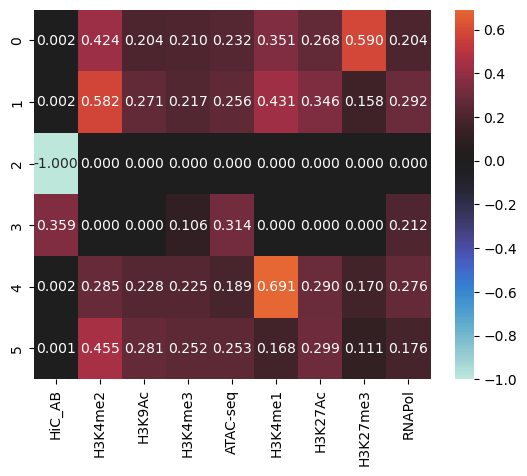

In [15]:
sns.heatmap(pd.DataFrame(gm.means_,columns = train[0].columns[4:]),center=0,annot=True,fmt='.3f')

In [16]:
tr_sig = torch.softmax(model.transition_model.unnormalized_transition_matrix,dim=1).detach().clone()

In [17]:
tr_sig

tensor([[0.0761, 0.1652, 0.1819, 0.0700, 0.3165, 0.1903],
        [0.1026, 0.0547, 0.1341, 0.3704, 0.1256, 0.2126],
        [0.0811, 0.5476, 0.1273, 0.1617, 0.0505, 0.0317],
        [0.2762, 0.1675, 0.1675, 0.1437, 0.1599, 0.0853],
        [0.0076, 0.0230, 0.3782, 0.0458, 0.5276, 0.0177],
        [0.2163, 0.0239, 0.4971, 0.0592, 0.0573, 0.1464]])

<Axes: >

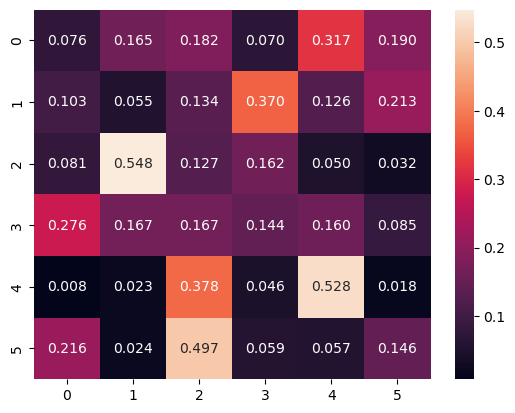

In [18]:
sns.heatmap(pd.DataFrame(tr_sig), annot=True,fmt='.3f')

In [19]:
torch.softmax(model.unnormalized_state_priors,dim=0).detach().clone().numpy()

array([4.1697815e-04, 1.0403295e-03, 9.9817407e-01, 5.1341915e-05,
       5.7920366e-05, 2.5940390e-04], dtype=float32)

<Axes: >

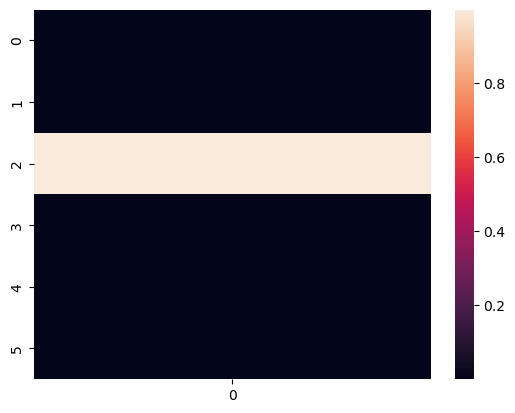

In [20]:
sns.heatmap(torch.softmax(model.unnormalized_state_priors,dim=0).detach().clone().numpy().reshape(-1,1))

In [21]:
next(enumerate(valid_dataset.loader))[1]

(tensor([[[-1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.4573],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
        dtype=torch.float64),
 tensor(1))

## Predicting RNA Pol Binding

In [22]:
class pred_RNA(pl.LightningModule):
  def __init__(self, N, M, mean=None, cov=None):
    from torch.distributions.multivariate_normal import MultivariateNormal
    super(pred_RNA, self).__init__()
    self.N = N
    self.M = M
    self.mean = torch.nn.ParameterList()
    self.cov = torch.nn.ParameterList()
    for i in range(self.N):
      self.mean.append(torch.nn.Parameter(mean[i,:],requires_grad=False))
      self.cov.append(torch.nn.Parameter(cov[i], requires_grad=False))
    self.dist = [MultivariateNormal(self.mean[i][:-1],self.cov[i][:-1,:-1]) for i in range(self.N)]
    self.dist_full = [MultivariateNormal(self.mean[i],self.cov[i]) for i in range(self.N)]
    
  def calculate_log_prob(self, x, n):
    pi=torch.tensor(np.pi).double()
    #log_prob = (1/(2*pi*torch.det(self.cov[n][:-1,:-1]))).log()+(-0.5*(x-self.mean[n][:-1])@torch.inverse(self.cov[n][:-1,:-1])@(x-self.mean[n][:-1]))
    log_prob = torch.log(1/torch.sqrt((2*pi)**((self.M-1)/2)*torch.sqrt(
        torch.det(self.cov[n][:-1,:-1])))) + -0.5*(x-self.mean[n][:-1])@torch.inverse(self.cov[n][:-1,:-1])@(x-self.mean[n][:-1]).T
    return log_prob
  
  def label(self, x):
    probs = torch.stack([self.dist[i].log_prob(x) for i in range(self.N)])
    return probs.max(dim=0)[1]
  
  def predict(self, x, keep_lab=False):
    label = self.label(x) # predict state using truncated covariance matrix
    C = self.dist_full[label].covariance_matrix # get covariance matrix from state
    #C = self.cov[label] # get covariance matrix from state
    P = self.dist[label].precision_matrix # get inverse of truncated covariance matrix
    #P = torch.inverse(C[:-1,:-1]) # get inverse of truncated covariance matrix
    m = self.mean[label] # mean of each marker
    pred = m[-1] + (C[-1,:-1]@P@(x-m[:-1]).reshape(-1,1)) # infer RNA using multivariate normal distribution
    if keep_lab:
      return pred, label
    else:
      return pred
  
  def forward(self,x):
    return torch.vstack([self.predict(i) for i in x]).squeeze()
  
  def training_step(self, batch, batch_idx):
    reads, T = batch
    test = self(reads.squeeze()[:,:-1])
    target = reads.squeeze()[:,-1]
    loss = torch.nn.functional.mse_loss(test, target)
    self.log("mse", loss)
    return loss
  
  def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer
      

  
  
  

In [23]:
import pandas as pd
import numpy as np
import os
import torch
dir = '/Users/fionshiau/Documents/2023Spring/Computational_Genomics/Final_Project/comp-geno-proj/'
mat = np.vstack([pd.read_csv(os.path.join(dir,'data','merged','1.4.{}_valid.csv'.format(i))).iloc[:,4:].to_numpy() for i in range(0,3)])


In [24]:
#from sklearn.mixture._gaussian_mixture import GaussianMixture
#import pickle
#gm = GaussianMixture(n_components = 6, random_state=0).fit(mat)
#gm = pickle.load(open('gm-final.sav','rb'))

In [25]:
gm

GaussianMixture(n_components=6, random_state=0, warm_start=True)

In [26]:
#gm = GaussianMixture(n_components = 11, random_state=0).fit(mat)
pred = pred_RNA(N=6, M=mat.shape[1],
                mean = torch.from_numpy(gm.means_).type(torch.float32), cov = torch.from_numpy(gm.covariances_).type(torch.float32))

### All validation DNA elements

In [27]:
# Test the model on all validation gene regions
from tqdm.notebook import tqdm
data = torch.tensor(mat).type(torch.float32)
test = torch.empty(size=(data.shape[0],1))
test_labs = torch.empty(size=(data.shape[0],1))
for idx, r in tqdm(enumerate(data),total=data.shape[0]):
    test[idx],test_labs[idx] = pred.predict(r[:-1],keep_lab=True)


  0%|          | 0/220908 [00:00<?, ?it/s]

In [28]:
torch.nn.functional.mse_loss(test,data[:,-1].reshape(-1,1))

tensor(0.0123)

[(0.0, 1.1), (-0.05, 1.0)]

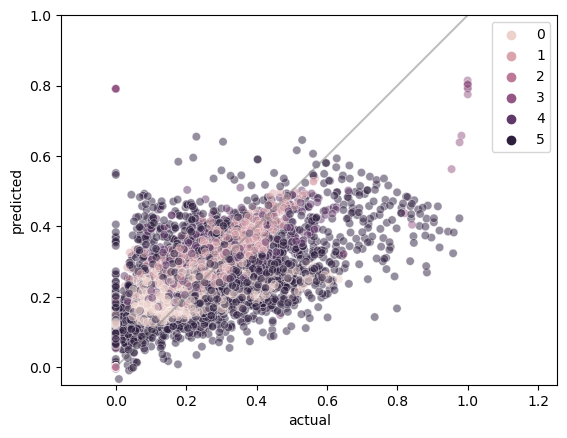

In [29]:
rng = np.random.default_rng(0)
sample_indices = rng.choice(mat.shape[0],size=10000)
g = sns.scatterplot(pd.DataFrame({'actual':mat[sample_indices,-1], 
                                  'predicted': test[sample_indices,:].numpy().reshape(-1),
                                  'labels' : test_labs[sample_indices,:].numpy().astype(int).reshape(-1)}),
                    x='actual',y='predicted',hue='labels',alpha=.5)
sns.lineplot(x = np.arange(0,1.1,.1),y=np.arange(0,1.1,.1), color = 'grey', alpha = .5)
g.axis('equal')
g.set(xlim=(0, 1.1), ylim=(-0.05, 1))



In [30]:
pearsonr(test.numpy().reshape(-1),mat[:,-1])

PearsonRResult(statistic=0.6509604817137322, pvalue=0.0)

### Test model on only promoters

In [31]:
prom = pd.read_csv('/Users/fionshiau/Library/CloudStorage/GoogleDrive-fioncshiau@gmail.com/.shortcut-targets-by-id/1lFT97diQ46tMlkSXaFO_BmMQeibiSn-H/ComputationalGenomics/PromotersSignal/merged_allData_promoters.csv')

In [32]:
prom.shape

(29200, 58)

In [33]:
prom.columns

Index(['Unnamed: 0', 'chr', 'start', 'end', 'H3K9Ac', 'H3K9Ac.1', 'H3K9Ac.2',
       'H3K9Ac.3', 'H3K9Ac.4', 'H3K9Ac.5', 'RNAPol', 'RNAPol.1', 'RNAPol.2',
       'RNAPol.3', 'RNAPol.4', 'RNAPol.5', 'RNAPol.6', 'RNAPol.7', 'RNAPol.8',
       'H3K4me3', 'H3K4me3.1', 'H3K4me3.2', 'H3K4me3.3', 'H3K4me3.4',
       'H3K4me3.5', 'H3K4me3.6', 'H3K4me3.7', 'H3K4me3.8', 'HiC_AB',
       'HiC_AB.1', 'HiC_AB.2', 'HiC_AB.3', 'H3K4me2', 'H3K4me2.1', 'H3K4me2.2',
       'H3K27me3', 'H3K27me3.1', 'H3K27me3.2', 'H3K27me3.3', 'H3K27me3.4',
       'H3K27me3.5', 'H3K27me3.6', 'H3K4me1', 'H3K4me1.1', 'H3K4me1.2',
       'H3K4me1.3', 'H3K4me1.4', 'H3K4me1.5', 'ATAC-seq', 'ATAC-seq.1',
       'ATAC-seq.2', 'ATAC-seq.3', 'ATAC-seq.4', 'ATAC-seq.5', 'ATAC-seq.6',
       'H3K27Ac', 'H3K27Ac.1', 'H3K27Ac.2'],
      dtype='object')

In [34]:
prom_1 = prom.loc[:,['HiC_AB', 'H3K4me2', 'H3K9Ac','H3K4me3', 'ATAC-seq', 'H3K4me1', 'H3K27Ac', 'H3K27me3', 'RNAPol']].to_numpy()

In [35]:
from sklearn.preprocessing import normalize
prom_1=normalize(X=prom_1, axis=1, norm='l2')

In [36]:
# Test the model
from tqdm.notebook import tqdm
prom_dat = torch.tensor(prom_1).type(torch.float32)
prom_test = torch.empty(size=(prom_dat.shape[0],1))
prom_test_labs = torch.empty(size=(prom_dat.shape[0],1))
for idx, r in tqdm(enumerate(prom_dat),total=prom_dat.shape[0]):
    prom_test[idx],prom_test_labs[idx] = pred.predict(r[:-1],keep_lab=True)


  0%|          | 0/29200 [00:00<?, ?it/s]

In [37]:
prom_test_labs.mode(axis=0)

torch.return_types.mode(
values=tensor([5.]),
indices=tensor([21900]))

In [38]:
torch.nn.functional.mse_loss(prom_test,prom_dat[:,-1].reshape(-1,1))

tensor(0.0303)

[(0.0, 1.1), (-0.05, 1.0)]

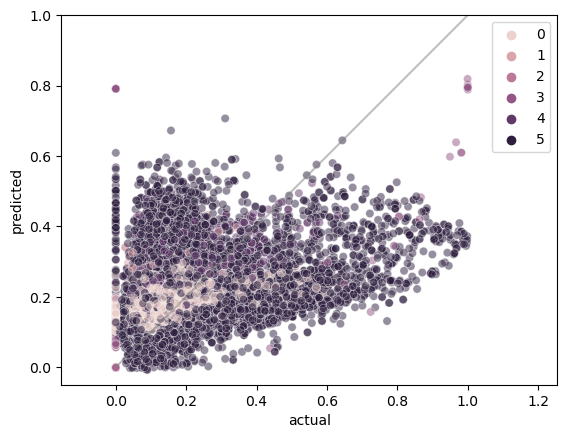

In [39]:
import seaborn as sns
rng = np.random.default_rng(0)
sample_indices = rng.choice(prom_1.shape[0],size=10000)
g = sns.scatterplot(pd.DataFrame({'actual':prom_1[sample_indices,-1], 
                                  'predicted': prom_test[sample_indices].numpy().reshape(-1),
                                  'labels' : prom_test_labs[sample_indices].numpy().astype(int).reshape(-1)}),
                    x='actual',y='predicted',hue='labels',alpha=.5)
sns.lineplot(x = np.arange(0,1.1,.1),y=np.arange(0,1.1,.1), color = 'grey', alpha = .5)
g.axis('equal')
g.set(xlim=(0, 1.1), ylim=(-0.05, 1))



In [40]:
pearsonr(prom_test.numpy().reshape(-1),prom_dat[:,-1])

PearsonRResult(statistic=0.2737293381939389, pvalue=0.0)